## Logistic Regression Model

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Read provided data from CVS-file and drop the first columns with ID's

In [2]:
data = pd.read_csv('Arthritis_on_heart_attack.csv')
print(data.shape)
print(list(data.columns))
data = data.drop(data.columns[0], axis=1)

(3788, 15)
['Unnamed: 0', 'arthritis.type', 'gender', 'bmi', 'diabetes', 'smoke', 'age', 'education', 'marriage', 'physical.activity', 'medical.access', 'blood.pressure', 'healthy.diet', 'covered.health', 'heart.attack']


In [3]:
data.head()

,arthritis.type,gender,bmi,diabetes,smoke,age,education,marriage,physical.activity,medical.access,blood.pressure,healthy.diet,covered.health,heart.attack
0,Non-arthritis,Male,"(25,80]",No,No,"(50,70]",School,Married,Moderate,Yes,No,Fair,No,No
1,Non-arthritis,Male,"(0,25]",No,No,"(19.9,50]",High.School,Not.married,No,Yes,No,Good,No,No
2,Non-arthritis,Male,"(25,80]",No,Yes,"(50,70]",High.School,Married,No,Yes,Yes,Good,Yes,No
3,Rheumatoid arthritis,Male,"(25,80]",Yes,No,"(50,70]",College,Married,No,Yes,Yes,Poor,Yes,No
4,Non-arthritis,Female,"(25,80]",No,No,"(19.9,50]",High.School,Married,Moderate,No,No,Fair,No,No


Use one-hot-encoding to convert data into binary classes

In [4]:
categories = ['arthritis.type', 'heart.attack', 'gender', 'bmi', 'diabetes', 'smoke',
          'age', 'education', 'marriage', 'physical.activity', 'medical.access',
          'blood.pressure', 'healthy.diet', 'covered.health']
for cat in categories:
    # get binary categories and join them with original dataframe
    binary_cat = pd.get_dummies(data[cat], prefix=cat)
    data = data.join(binary_cat)
# Drop original impact feature columns and keep preprocessed, binary classes in new dataframe
column_names = data.columns.values.tolist()
to_keep = [i for i in column_names if i not in categories]
df = data[to_keep].copy()

In [5]:
df.head()

,arthritis.type_Non-arthritis,arthritis.type_Rheumatoid arthritis,heart.attack_No,heart.attack_Yes,gender_Female,gender_Male,"bmi_(0,25]","bmi_(25,80]",diabetes_No,diabetes_Yes,...,physical.activity_No,medical.access_No,medical.access_Yes,blood.pressure_No,blood.pressure_Yes,healthy.diet_Fair,healthy.diet_Good,healthy.diet_Poor,covered.health_No,covered.health_Yes
0,1,0,1,0,0,1,0,1,1,0,...,0,0,1,1,0,1,0,0,1,0
1,1,0,1,0,0,1,1,0,1,0,...,1,0,1,1,0,0,1,0,1,0
2,1,0,1,0,0,1,0,1,1,0,...,1,0,1,0,1,0,1,0,0,1
3,0,1,1,0,0,1,0,1,0,1,...,1,0,1,0,1,0,0,1,0,1
4,1,0,1,0,1,0,0,1,1,0,...,0,1,0,1,0,1,0,0,1,0


Select only the impact features from the dataset for the X-data, and take the arthritis.type as y-data.
Heart.attack data should not be considered for this model, since we want to know the effect of the other parameters on heart attacks.

In [6]:
X = df.copy()
drop_columns = ['heart.attack_No' , 'heart.attack_Yes', 'arthritis.type_Non-arthritis',
                'arthritis.type_Rheumatoid arthritis']
X = X.drop(drop_columns , axis='columns')
y = df.loc[:, df.columns == 'arthritis.type_Rheumatoid arthritis']

In [7]:
data['arthritis.type'].value_counts()

Non-arthritis           3544
Rheumatoid arthritis     244
Name: arthritis.type, dtype: int64

There are many more data points of the Non-arthritis class, therefore we will have to use class-weights.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression(class_weight="balanced")
logreg.fit(X_train, y_train.values.ravel())

LogisticRegression(class_weight='balanced')

In [9]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.68


In [10]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[478 232]
 [ 13  35]]


The majority of cases of each class are predicted correctly (478 and 35)

## Task 1: Compute Propensity Scores

In this case the propensity score is the predicted probability of a patient to have Rheumatoid Arthritis based on the impact features. Use the logistic regression model to predict the output values of the model provided X.

In [11]:
# predict_proba returns list of two values, the probability of the prediction being negative or positive
propensity_scores = logreg.predict_proba(X)[:,1] 

Add propensity scores to dataset:

In [12]:
df.loc[:,'propensity_score'] = propensity_scores

Setting the caliper to 0.2 of the standard deviation of the logit of the propensity score.

In [13]:
from scipy.special import logit
from numpy import std

caliper = 0.2 * std(logit(df['propensity_score']))
print(caliper)

0.22353609947927106


## Task 2: Matching

Splitting the dataset into patients with RA and non-RA and saving those as new dataframes.
Creating a copy of those dataframes which represent the datasets pre-matching.
Add another empty column to each dataset for partner-ID for the matching.

In [14]:
treatment_group = df.loc[df['arthritis.type_Rheumatoid arthritis'] == 1].copy()
control_group = df.loc[df['arthritis.type_Non-arthritis'] == 1].copy()
treatment_group_prematch = treatment_group.copy()
control_group_prematch = control_group.copy()
treatment_group['partner'] = [None] * len(treatment_group.index)
control_group['partner'] = [None] * len(control_group.index)

Matching function to find a matching partner for the treatment group patients in the control group.

In [15]:
def match():
    # for each patient in the treatment group
    for t_index, t_row in treatment_group.iterrows():
        # look at every patient in the control group
        for c_index, c_row in control_group.iterrows():
            # if the propensity score is similar enough and the control patient has no partner:
            if abs(t_row['propensity_score'] - c_row['propensity_score']) < caliper:
                if c_row['partner'] == None:
                    # assign them as partners and go to next treatment patient
                    treatment_group.at[t_index, 'partner'] = c_index
                    control_group.at[c_index, 'partner'] = t_index
                    break

In [16]:
match()

Remove those that did not find a partner.

In [17]:
treatment_group = treatment_group[treatment_group['partner'].notnull()]
control_group = control_group[control_group['partner'].notnull()]

Check if the control group and treatment group are of the same size

In [18]:
len(control_group.index) == len(treatment_group.index)

True

## Task 3: Visualize Propensity Scores

Plot the number of propensity scores in intervals.

Before matching:

(0.0, 2.5)

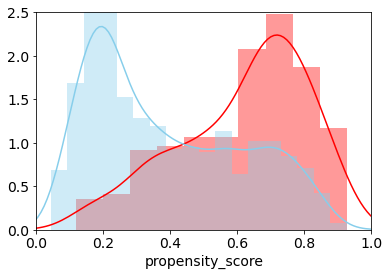

In [19]:
sns.distplot(treatment_group_prematch['propensity_score'] , color="red")
sns.distplot(control_group_prematch['propensity_score'] , color="skyblue")
plt.xlim(0, 1.0)
plt.ylim(0, 2.5)

After matching:

(0.0, 2.5)

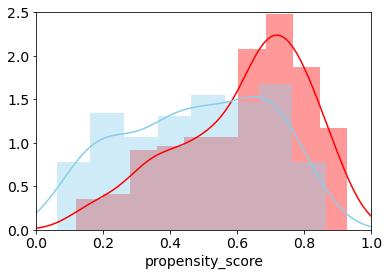

In [20]:
sns.distplot(treatment_group['propensity_score'] , color="red")
sns.distplot(control_group['propensity_score'] , color="skyblue")
plt.xlim(0, 1.0)
plt.ylim(0, 2.5)

After matching, the propensity scores of the control group became more similar to those of the treatment group.

## Task 4: Balance Table of Average Feature Values

The coefficients of the Logistic Regression model can be used to find the features, that have the most influence on the predicted class. Positive values will contribute to the prediction of RA, whereas negative values contribute to non-RA.

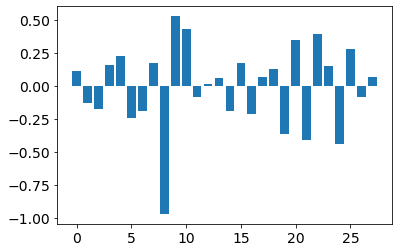

In [21]:
coefficients = logreg.coef_[0]

# Plot the influence of the features on the prediction
plt.bar([x for x in range(len(coefficients))], coefficients)

# Convert the list of coefficients to a dict with their list index as key
dict_coef_indices = {i: coef for i, coef in enumerate(coefficients)}

# Selecting the 5 most influencial features for RA and non-RA respectively
coef_RA = sorted(dict_coef_indices, key=dict_coef_indices.get, reverse=True)[:5]
coef_non_RA = sorted(dict_coef_indices, key=dict_coef_indices.get, reverse=False)[:5]

In [22]:
# Function for plotting a table using a list of coefficient indices
def create_coefficient_table(coef_indices):
    columns = ['Label', 'Control group prematch', 'Control group postmatch', 'Treatment group']
    table_data = []
    for index in coef_indices:
        row = []
        label = X.columns[index]
        row.append(label)
        # Compute the average of values for the particular feature for each group
        row.append("{:.3f}".format(control_group_prematch[label].mean()))
        row.append("{:.3f}".format(control_group[label].mean()))
        row.append("{:.3f}".format(treatment_group[label].mean()))
        table_data.append(row)
    df_coef = pd.DataFrame(table_data, columns=columns)
    df_coef.index += 1
    return df_coef

Contribute to RA prediction:

In [23]:
create_coefficient_table(coef_RA)

,Label,Control group prematch,Control group postmatch,Treatment group
1,"age_(50,70]",0.252,0.398,0.520
2,"age_(70,81]",0.106,0.148,0.217
3,blood.pressure_Yes,0.259,0.352,0.566
4,medical.access_Yes,0.813,0.873,0.951
5,healthy.diet_Poor,0.054,0.057,0.094


Contribute to non-RA prediction:

In [24]:
create_coefficient_table(coef_non_RA)

,Label,Control group prematch,Control group postmatch,Treatment group
1,"age_(19.9,50]",0.642,0.455,0.262
2,healthy.diet_Good,0.714,0.734,0.656
3,blood.pressure_No,0.741,0.648,0.434
4,medical.access_No,0.187,0.127,0.049
5,diabetes_Yes,0.084,0.115,0.115


Most of the features that were selected as influencial make sense, such as old age and poor diet contributing to RA. However, some do not make sense in the context, such as medical access contributing to RA, or diabetes contributing to non-RA.

In 9 out of 10 cases considered, the average value of the features of the control group became closer to the treatment group after the matching was done.

## Step 5: Visualize Heart Attack Rates

In [25]:
# Count the number of heart attacks or no heart attacks in both groups, classes are in [0], counts in [1]
HA_RA = np.unique(treatment_group['heart.attack_Yes'], return_counts=True)
HA_non_RA = np.unique(control_group['heart.attack_Yes'], return_counts=True)

HA = pd.DataFrame({'RA': HA_RA[1], 'non RA': HA_non_RA[1]},
                  index=['No HA', 'HA'])
HA.T # Transpose to invert axis in table

,No HA,HA
RA,224,20
non RA,238,6


<AxesSubplot:ylabel='RA'>

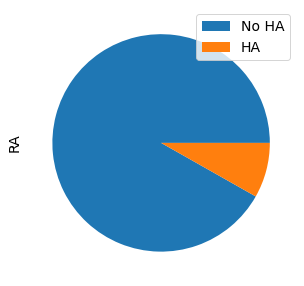

In [26]:
HA.plot.pie(y='RA', figsize=(5, 5), labels=None)

<AxesSubplot:ylabel='non RA'>

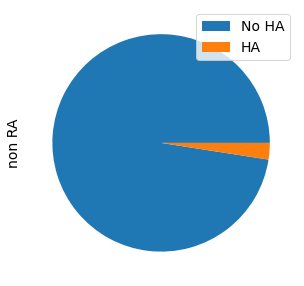

In [27]:
HA.plot.pie(y='non RA', figsize=(5, 5), labels=None)

### Considering this dataset;  patients with similar risk factors, which were selected by matching them with partners who have a propensity score difference within a defined caliper value, had a higher rate of heart attacks if they have Rheumatoid Arthritis as opposed to having no Rheumatoid Arthritis. Therefore, according to this model, RA would increase the risk of having a heart attack.